## Abstract:
One of the key activities of any IT function is to ensure there is no
impact to the Business operations. <b>IT leverages Incident Management process to achieve the
above Objective.</b> An incident is something that is unplanned interruption to an IT service or
reduction in the quality of an IT service that affects the Users and the Business. <b><i>The main goal
of Incident Management process is to provide a quick fix / workarounds or solutions that resolves the interruption and restores the service to its full capacity to ensure no business impact.</i></b>

In most of the organizations, incidents are created by various Business and IT Users, End Users/ Vendors if they have access to ticketing systems, and from the integrated monitoring
systems and tools. <b>Assigning the incidents to the appropriate person or unit in the support team has critical importance to provide improved user satisfaction while ensuring better allocation of support resources.</b>

<i> Manual assignment of incidents is time consuming and requires human efforts. There may be mistakes due to human errors and resource consumption is carried out ineffectively because of the misaddressing. On the other hand, manual assignment increases the response and resolution times which result in user satisfaction deterioration / poor customer service.</i>
#### <b>Business Domain Value:</b> 
In the support process, incoming incidents are analyzed and assessed by organization’s support teams to fulfill the request. In many organizations, better allocation and effective usage of the valuable support resources will directly result in substantial cost savings.

Currently the incidents are created by various stakeholders (Business Users, IT Users and Monitoring Tools) within IT Service Management Tool and are assigned to Service Desk teams (L1 / L2 teams). This team will review the incidents for right ticket categorization, priorities and then carry out initial diagnosis to see if they can resolve. Around ~54% of the incidents are resolved by L1 / L2 teams. Incase L1 / L2 is unable to resolve, they will then escalate / assign the tickets to Functional teams from Applications and Infrastructure (L3 teams). Some portions of incidents are directly assigned to L3 teams by either Monitoring tools or Callers / Requestors. L3 teams will carry out detailed diagnosis and resolve the incidents. Around ~56%
of incidents are resolved by Functional / L3 teams. Incase if vendor support is needed, they will reach out for their support towards incident closure.

L1 / L2 needs to spend time reviewing Standard Operating Procedures (SOPs) before assigning to Functional teams (Minimum ~25-30% of incidents needs to be reviewed for SOPs before ticket assignment). 15 min is being spent for SOP review for each incident. Minimum of ~1 FTE effort needed only for incident assignment to L3 teams. During the process of incident assignments by L1 / L2 teams to functional groups, there were multiple instances of incidents getting assigned to wrong functional groups. Around ~25% of Incidents are wrongly assigned to functional teams. Additional effort needed for Functional teams to re-assign to right functional groups. During this process, some of the incidents are in queue and not addressed timely resulting in poor customer service.

## Objective:
### Build Multi-Class classifier that can classify the tickets by analysing text.###
Guided by powerful AI techniques that can classify incidents to right functional groups can help organizations to reduce the resolving time of the issue and can focus on more productive tasks.
### Milestones
1. Milestone 1: Pre-Processing, Data Visualisation and EDA
  1. Exploring the given Data files
  2. Understanding the structure of data
  3. Missing points in data
  4. Finding inconsistencies in the data
  5. Visualizing different patterns
  6. Visualizing different text features
  7. Dealing with missing values
  8. Text preprocessing
  9. Creating word vocabulary from the corpus of report text data
  10. Creating tokens as required

2. Milestone 2: Model Building
  1. Building a model architecture which can classify.
  2. Trying different model architectures by researching state of the art for similar tasks.
  3. Train the model
  4. To deal with large training time, save the weights so that you can use them when training the model for the second time without starting from scratch.

3. Milestone 3: Test the Model, Fine-tuning and Repeat
  1. Test the model and report as per evaluation metrics
  2. Try different models
  3. Try different evaluation metrics
  4. Set different hyper parameters, by trying different optimizers, loss functions, epochs, learning rate, batch size, checkpointing, early stopping etc..for these models to fine-tune them
  5. Report evaluation metrics for these models along with your observation on how changing different hyper parameters leads to change in the final evaluation metric.
---

### <u>Imports and Configurations</u>
Section to import all necessary packages. Install the libraries which are not included in Anaconda distribution by default using pypi channel or conda forge
**``!pip install ftfy wordcloud goslate spacy inflect``**<br/>
**``conda install -c conda-forge ftfy wordcloud goslate spacy inflect``**

In [1]:
# Utilities
from time import time
from zipfile import ZipFile
import os, sys, itertools, string
import warnings, pickle, inflect, re
from ftfy import fix_encoding, fix_text, badness
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Translation APIs
from goslate import Goslate # Provided by Google

# Numerical calculation
import numpy as np

# Data Handling
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot

# Sequential Modeling
import keras.backend as K
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Embedding, LSTM, TimeDistributed, Conv1D, MaxPooling1D
from keras.constraints import max_norm, unit_norm
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

# Tools & Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.metrics import roc_curve, accuracy_score, precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import RandomOverSampler

# NLP toolkits
import spacy
import nltk
from nltk import tokenize

Using TensorFlow backend.


In [2]:
# Configure for any default setting of any library
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')
init_notebook_mode(connected=True)
cf.go_offline()
%matplotlib inline

- Extract Glove 6Billion word embeddings. We're going to use the 200d file which has 200 embedding dimensions for each word in the corpus.
- Load the bodies and headlines CSVs for both training and test data and join them together individually to form datasets.

### <u>Set the working directory</u>
Mount the drive and set the project path to cureent working directory, when running in Google Colab. No changes are required in case of running in Local PC.

In [3]:
# Block which runs on both Google Colab and Local PC without any modification
if 'google.colab' in sys.modules:    
    project_path = "/content/drive/My Drive/Colab Notebooks/DLCP/Capstone-NLP/"
    # Google Colab lib
    from google.colab import drive
    # Mount the drive
    drive.mount('/content/drive/', force_remount=True)
    sys.path.append(project_path)
    %cd $project_path

# Let's look at the sys path
print('Current working directory', os.getcwd())

Current working directory D:\Hands-On\PGP-AIML\CaseStudies\Capstone Projects\1-NLP-Automatic.Ticket.Assignment


### <u>Extract Glove Embeddings</u>
- Extract Glove 6Billion word embeddings. We're going to use the 200d file which has 200 embedding dimensions for each word in the corpus.

In [4]:
# Check if it is already extracted else Open the zipped file as readonly
if not os.path.isfile('glove.6B/glove.6B.200d.txt'):
    glove_embeddings = 'glove.6B.zip'
    with ZipFile(glove_embeddings, 'r') as archive:
        archive.extractall('glove.6B')

# List the files under extracted folder
os.listdir('glove.6B')

['glove.6B.100d.txt',
 'glove.6B.200d.txt',
 'glove.6B.300d.txt',
 'glove.6B.50d.txt']

---
### <u>Load the dataset</u>

In [5]:
# Load the dataset into a Pandas dataframe called ticket and check the head of the dataset
ticket = pd.read_excel('Input Data Synthetic (created but not used in our project).xlsx', )
ticket.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [6]:
# Check the tail of the dataset
ticket.tail()

,Short description,Description,Caller,Assignment group
8495,emails not coming in from zz mail,\r\n\r\nreceived from: avglmrts.vhqmtiua@gmail...,avglmrts vhqmtiua,GRP_29
8496,telephony_software issue,telephony_software issue,rbozivdq gmlhrtvp,GRP_0
8497,vip2: windows password reset for tifpdchb pedx...,vip2: windows password reset for tifpdchb pedx...,oybwdsgx oxyhwrfz,GRP_0
8498,machine nÃ£o estÃ¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,GRP_62
8499,an mehreren pc`s lassen sich verschiedene prgr...,an mehreren pc`s lassen sich verschiedene prgr...,kqvbrspl jyzoklfx,GRP_49


**Comments**
* To take a closer look at the data, pandas library provides **“.head()”** function which returns first five observations and **“.tail()”** function which returns last five observations of the data set.

### <u>Inspect the Dataset</u>
The dataset is divided into two parts, namely, **feature matrix** and the **response vector**.

- Feature matrix contains all the vectors(rows) of dataset in which each vector consists of the value of **dependent features**. In above dataset, features are *Short description*, *Description* and *Caller*.
- Response vector contains the value of **class variable**(prediction or output) for each row of feature matrix. In above dataset, the class variable name is *Assignment group*.

In [7]:
# Get the shape and size of the dataset
print('No of rows:\033[1m', ticket.shape[0], '\033[0m')
print('No of cols:\033[1m', ticket.shape[1], '\033[0m')

No of rows: 8500 
No of cols: 4 


In [8]:
# Get more info on it
# 1. Name of the columns
# 2. Find the data types of each columns
# 3. Look for any null/missing values
ticket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
Short description    8492 non-null object
Description          8499 non-null object
Caller               8500 non-null object
Assignment group     8500 non-null object
dtypes: object(4)
memory usage: 265.8+ KB


In [9]:
# Describe the dataset with various summary and statistics
ticket.describe()

,Short description,Description,Caller,Assignment group
count,8492,8499,8500,8500
unique,7481,7817,2950,74
top,password reset,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,810,3976


In [10]:
# Check the Short description of tickets having Description as only 'the'
ticket[ticket.Description == 'the'].head()

,Short description,Description,Caller,Assignment group
1049,reset passwords for soldfnbq uhnbsvqd using pa...,the,soldfnbq uhnbsvqd,GRP_17
1054,reset passwords for fygrwuna gomcekzi using pa...,the,fygrwuna gomcekzi,GRP_17
1144,reset passwords for wvdxnkhf jirecvta using pa...,the,wvdxnkhf jirecvta,GRP_17
1184,reset passwords for pxvjczdt kizsjfpq using pa...,the,pxvjczdt kizsjfpq,GRP_17
1292,reset passwords for cubdsrml znewqgop using pa...,the,cubdsrml znewqgop,GRP_17


In [11]:
# Find out the null value counts in each column
ticket.isnull().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

**Observations**
- The dataset comprises of **8500 rows** and **4 columns**
- All columns are of type object containing textual information.
- There are **8 null/missing values** present in the Short description and **1 null/missing values** present in the description column
- **Password reset** is one of the most occuring tickets which reflects in the Short description column.
- The top occuring Description in the dataset is only the text **'the'**, which absolutely doesn't make any sense. hence by looking at the Short description of such rows reveals that these are also a category of Password reset.

### <u>NULL treatment</u>

In [12]:
# Let's look at the rows with null values
ticket[pd.isnull(ticket).any(axis=1)]

,Short description,Description,Caller,Assignment group
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,ohdrnswl rezuibdt,GRP_34
3383,NaN,\r\n-connected to the user system using teamvi...,qftpazns fxpnytmk,GRP_0
3906,NaN,-user unable tologin to vpn.\r\n-connected to...,awpcmsey ctdiuqwe,GRP_0
3910,NaN,-user unable tologin to vpn.\r\n-connected to...,rhwsmefo tvphyura,GRP_0
3915,NaN,-user unable tologin to vpn.\r\n-connected to...,hxripljo efzounig,GRP_0
3921,NaN,-user unable tologin to vpn.\r\n-connected to...,cziadygo veiosxby,GRP_0
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,wvqgbdhm fwchqjor,GRP_0
4341,NaN,\r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...,eqmuniov ehxkcbgj,GRP_0
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


In [13]:
# NULL replacement
ticket.fillna(str(), inplace=True)
ticket[pd.isnull(ticket).any(axis=1)]

,Short description,Description,Caller,Assignment group


In [14]:
# verify the replacement
ticket.isnull().sum()

Short description    0
Description          0
Caller               0
Assignment group     0
dtype: int64

**Comments**:
- We have various ways of treating the NULL/Missing values in the dataset such as 
    - Replacing them with empty string 
    - Replacing them with some default values
    - Duplicating the Short description and Description values wherever one of them is Null
    - Dropping the records with null/missing values completely.
- We're not choosing to drop any record as we don't want to loose any information. And as we're going to concatenate the Short description and Description columns for each record while feeding them into NLP, we neither want to pollute the data by introducing any default values nor bias it by duplicating the description colomns.
- Hence our NULL/Missing value treatment replaces the NaN cells with just empty string.

### <u>Mojibake </u>
[Mojibake](https://en.wikipedia.org/wiki/Mojibake) is the garbled text that is the result of text being decoded using an unintended character encoding. The result is a systematic replacement of symbols with completely unrelated ones, often from a different writing system.<br/>
This display may include the generic replacement character ("�") in places where the binary representation is considered invalid. A replacement can also involve multiple consecutive symbols, as viewed in one encoding, when the same binary code constitutes one symbol in the other encoding. This is either because of differing constant length encoding (as in Asian 16-bit encodings vs European 8-bit encodings), or the use of variable length encodings (notably UTF-8 and UTF-16). Few such Mojibakes are **¶**, **ç**, **å**, **€**, **æ**, **œ**, **º**, **‡**, **¼**, **¥** etc.

As we're dealing with Natural Language and the source of the data is unknown to us, let's run the encoding check to figure out if the dataset is Mojibake impacted.

The library **ftfy** (Fixes Text For You) has a greater ability to detect, fix and deal with such Mojibakes. It fixes Unicode that’s broken in various ways. The goal of ftfy is to take in bad Unicode and output good Unicode.

Installation:<br/>
using pypi: **`!pip install ftfy`**<br/>
using conda: **`conda install -c conda-forge ftfy`**

In [15]:
# Write a function to apply to the dataset to detect Mojibakes
def is_mojibake_impacted(text):
    if not badness.sequence_weirdness(text):
        # nothing weird, should be okay
        return True
    try:
        text.encode('sloppy-windows-1252')
    except UnicodeEncodeError:
        # Not CP-1252 encodable, probably fine
        return True
    else:
        # Encodable as CP-1252, Mojibake alert level high
        return False
    
# Check the dataset for mojibake impact
ticket[~ticket.iloc[:,:-1].applymap(is_mojibake_impacted).all(1)]

,Short description,Description,Caller,Assignment group
99,password expiry tomorrow,\n\nreceived from: ecprjbod.litmjwsy@gmail.com...,ecprjbod litmjwsy,GRP_0
116,server issues,\r\n\r\nreceived from: bgqpotek.cuxakvml@gmail...,bgqpotek cuxakvml,GRP_0
124,mobile device activation,"from: tvcdfqgp nrbcqwgj \nsent: friday, octobe...",tvcdfqgp nrbcqwgj,GRP_0
164,æ’¤å›ž: ticket_no1564867 -- comments added,\n\nreceived from: abcdri@company.com\n\nwindy...,tycludks cjofwigv,GRP_0
170,[urgent!!] delivery note creation request!!,\n\nreceived from: fbvpcytz.nokypgvx@gmail.com...,fbvpcytz nokypgvx,GRP_18
...,...,...,...,...
8470,please review your recent ticketing_tool ticke...,"from: mikhghytr wafglhdrhjop \nsent: thursday,...",azxhejvq fyemlavd,GRP_16
8471,ç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥,to å°è´ºï¼Œæ—©ä¸Šç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥,xqyjztnm onfusvlz,GRP_30
8480,customer group enhanced field,\r\n\r\nreceived from: nlearzwi.ukdzstwi@gmail...,nlearzwi ukdzstwi,GRP_9
8498,machine nÃ£o estÃ¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,GRP_62


In [16]:
# Take an example of row# 8471 Short Desc and fix it
print('Grabled text: \033[1m%s\033[0m\nFixed text: \033[1m%s\033[0m' % (ticket['Short description'][8471], 
                                                                        fix_text(ticket['Short description'][8471])))

# List all mojibakes defined in ftfy library
print('\nMojibake Symbol RegEx:\n', badness.MOJIBAKE_SYMBOL_RE.pattern)

Grabled text: ç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥
Fixed text: 电脑开机开不出来

Mojibake Symbol RegEx:
 [ÂÃĂ][-€ƒ‚„†‡ˆ‰‹Œ“•˜œŸ¡¢£¤¥¦§¨ª«¬¯°±²³µ¶·¸¹º¼½¾¿ˇ˘˝]|[ÂÃĂ][›»‘”©™]\w|[¬√][ÄÅÇÉÑÖÜáàâäãåçéèêëíìîïñúùûü†¢£§¶ß®©™≠ÆØ¥ªæø≤≥]|\w√[±∂]\w|[ðđ][Ÿ]|â€|вЂ[љћ¦°№™ќ“”]


In [17]:
# Sanitize the dataset from Mojibakes
ticket['Short description'] = ticket['Short description'].apply(fix_text)
ticket['Description'] = ticket['Description'].apply(fix_text)

# Visualize that row# 8471
ticket.iloc[8471,:]

Short description             电脑开机开不出来
Description           to 小贺,早上电脑开机开不出来
Caller               xqyjztnm onfusvlz
Assignment group                GRP_30
Name: 8471, dtype: object

In [18]:
# Serialize the mojibake treated dataset
ticket.to_csv('mojibake_encoded.csv', index=False, encoding='utf_8_sig')
with open('mojibake_treated.pkl', 'wb') as handle:
    pickle.dump(ticket, handle, protocol=pickle.HIGHEST_PROTOCOL)

**Comments:**
- `badness.sequence_weirdness()` determines how often a text has unexpected characters or sequences of characters. This metric is used to disambiguate when text should be re-decoded or left as is.
- We're successfuly able to get the grabled characters back into their original form using **ftfy.fix_text()``**, however it is observed that the row# 8471 is not English but Mandarine.
- So the data in our hand is multilingual and it is quite not possible to derive embeddings for mix of multiple languages. We're going to translate the entire dataset into a single language of English.

### <u>Language Translation (Goslate: Free Google Translate API)</u>
Goslate is an open source python library that implemented Google Translate API. This uses the [Google Translate Ajax API](https://translate.google.com/) to make calls to such methods as detect and translate. It is choosen over another library Googletrans from Google as Goslate is developed to bypass the ticketing mechanism to prevent simple crawler program to access the Ajax API. Hence Goslate with multiple service urls is able to translate the entire dataset in very few iterations without blocking the user's IP address.

Installation:<br/>
using pypi: **`!pip install goslate`**<br/>
using conda: **`conda install -c conda-forge goslate`**

Servicce Urls used:
**``translate.google.com``**, **``translate.google.com.au``**, **``translate.google.com.ar``**, **``translate.google.co.kr``**, **``translate.google.co.in``**, **``translate.google.co.jp``**, **``translate.google.at``**, **``translate.google.de``**, **``translate.google.ru``**, **``translate.google.ch``**, **``translate.google.fr``**, **``translate.google.es``**, **``translate.google.ae``**

In [19]:
# Define and construct the service urls
svc_domains = ['.com','.com.au','.com.ar','.co.kr','.co.in','.co.jp','.at','.de','.ru','.ch','.fr','.es','.ae']
svc_urls = ['http://translate.google' + domain for domain in svc_domains]

# Take an example of row# 8471 Short Desc and fix it
gs = Goslate(service_urls=svc_urls)
trans_8471 = gs.translate(ticket['Short description'][8471], target_language='en', source_language='auto')
print('Original text: \033[1m%s\033[0m\nFixed text: \033[1m%s\033[0m' % (ticket['Short description'][8471], trans_8471))

Original text: 电脑开机开不出来
Fixed text: Boot the computer does not really come out


In [20]:
# # List of column data to consider for translation
# trans_cols = ['Short description','Description']
# for idx in range(ticket.shape[0]):
#     # Instantiate Goslate class in each iteration
#     gs = Goslate(service_urls=svc_urls)
#     row_iter = gs.translate(ticket.loc[idx, trans_cols].tolist(), 
#                             target_language='en', 
#                             source_language='auto')
#     ticket.loc[idx, trans_cols] = list(row_iter)

In [21]:
# # Serialize the translated dataset
# ticket.to_csv('translated_ticket.csv', index=False, encoding='utf_8_sig')
# with open('translated_ticket.pkl','wb') as f:
#     pickle.dump(ticket, f, pickle.HIGHEST_PROTOCOL)

In [2]:
# DELETE THIS CELL BEFORE SUBMITTING
with open('translated_ticket.pkl','rb') as f:
    ticket = pickle.load(f)

**Comments**:
- Unless paid service is used, Google blocks repetative hits to its Ajax API either via Googletrans or Goslate after certain iterations by cloagging the IP address.
- Using these list of various domains of translation API as service urls helped the traffic being patched among themselves, in turn allowing a longer buffer before the IP gets blocked.

### <u>Text Preprocessing</u>
Text preprocessing is the process of transferring text from human language to machine-readable format for further processing. After a text is obtained, we start with text normalization. Text normalization includes:
- converting all letters to lower or upper case
- converting numbers into words or removing numbers
- removing punctuations, accent marks and other diacritics
- removing white spaces
- removing stop words, sparse terms, and particular words
- text canonicalization

In [3]:
# Define regex patterns
EMAIL_PATTERN = r"[\w.+-]+@[a-z\d-]+\.[a-z\d.-]+"
PUNCT_PATTERN = r"[,|@|\|?|\\|$&*|%|\r|\n|.:|\s+|/|//|\\|/|\||-|<|>|;|(|)|=|+|#|-|\"|[-\]]|{|}]"
NUMER_PATTERN = r'(\d+(?:\.\d+)?)'

# Define a function to treat the texts
def cleanseText(text):
    # Make the text unicase (lower) 
    text = str(text).lower()
    # Remove email adresses
    text = re.sub(EMAIL_PATTERN, '', text, flags=re.IGNORECASE)
    # Remove all numbers 
    text = re.sub(NUMER_PATTERN, '', text)
    # Replace all punctuations with blank space
    text = re.sub(PUNCT_PATTERN, " ", text, flags=re.MULTILINE)
    # text = text.translate(str.maketrans("","", string.punctuation))
    # Replace multiple spaces from prev step to single
    text = re.sub(r' {2,}', " ", text, flags=re.MULTILINE)
    text = text.replace('`',"'")
    return text.strip()

In [4]:
# Take an example of row# 32 Description and fix it
print('\033[1mOriginal text:\033[0m')
print(ticket['Description'][32])
print('_'*100)
print('\033[1mCleaned text:\033[0m')
print(cleanseText(ticket['Description'][32]))

Original text:
received from: kxsceyzo.naokumlb@gmail.com

gentles,

i have two devices that are trying to share an ip address. they are trying to share 96.26.27.9619. one is a printer with the hostname of prtjc0074, and the other is a new display for erp. the display is using dhcp to get its address assigned and the printer is hard coded.

my guess is that the address 96.26.27.9619 did not get set to a static address in dhcp. i need this corrected so the display will pick up another address.
____________________________________________________________________________________________________
Cleaned text:
received from gentles i have two devices that are trying to share an ip address they are trying to share one is a printer with the hostname of prtjc and the other is a new display for erp the display is using dhcp to get its address assigned and the printer is hard coded my guess is that the address did not get set to a static address in dhcp i need this corrected so the display will 

In [5]:
# Apply the cleaning function to entire dataset
ticket['Description'] = ticket['Description'].apply(cleanseText)
ticket['Short description'] = ticket['Short description'].apply(cleanseText)

# Verify the data
ticket.tail()

,Short description,Description,Caller,Assignment group
8495,emails not coming in from zz mail,received from good afternoon i am not receivin...,avglmrts vhqmtiua,GRP_29
8496,telephony_software issue,telephony_software issue,rbozivdq gmlhrtvp,GRP_0
8497,vip windows password reset for tifpdchb pedxruyf,vip windows password reset for tifpdchb pedxruyf,oybwdsgx oxyhwrfz,GRP_0
8498,machine is not working,i am unable to access the machine utilities to...,ufawcgob aowhxjky,GRP_62
8499,various prgramdntyme can not be opened on mult...,various prgramdntyme can not be opened on mult...,kqvbrspl jyzoklfx,GRP_49


**Comments:**
- Entire dataset is converted into lower case
- Users email addresses will add NO value to our analysis, despite the fact that user id is given in the caller column. So all email adresses are removed from the dataset
- All numerals are removed because they were dominating the dataset if we were converting them into their word representation otherwise.
- All punctuation marks are removed which used to be a hindrance in lemmatization.
- All occurances of more than one blank spaces, horizontal tab spaces, new line breaks etc. have been replaced with single blank space.

Now with a nice and cleaner data in our hand let's proceed towards Lemmatization.
### <u>Stemming and Lemmatization</u>
Stemming and Lemmatization are Text Normalization (or sometimes called Word Normalization) techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing.<br/>
In grammar, inflection is known as the modification of a word to express different grammatical categories such as tense, case, voice, aspect, person, number, gender, and mood. An inflection expresses one or more grammatical categories with a prefix, suffix or infix, or another internal modification such as a vowel change.

**Stemming**<br/>
Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language.

**Lemmatization**<br/>
Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

### spaCy
The [spaCy](https://spacy.io/) library is one of the most popular NLP libraries along with NLTK which contains only one, but the best algorithm to solve any Natural Language problem. Once it is downloaded and installed, the next step is to download the language model, which is used to perform a variety of NLP tasks.

Installation:<br/>
using pypi: **`!pip install spacy`**<br/>
using conda: **`conda install -c conda-forge spacy`**

Language Model Download:<br/>
**``$ python -m spacy download en_core_web_md``**

In [6]:
# Initialize spacy 'en' medium model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

# Define a function to lemmatize the descriptions
def lemmatizer(sentence):
    # Parse the sentence using the loaded 'en' model object `nlp`
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc if token.lemma_ !='-PRON-'])

In [7]:
# Take an example of row# 43 Description and lemmatize it
print('\033[1mOriginal text:\033[0m')
print(ticket['Description'][43])
print('_'*100)
print('\033[1mLemmatized text:\033[0m')
print(lemmatizer(ticket['Description'][43]))

Original text:
received from hi - the printer printer is not working and needs a part replaced can you reroute the jobs in queue to printer printer wihuyjdo qpogfwkb has indicated that prqos needs a new part and it may not deliver for a few days so the inwarehouse_tools will need to print on printer for now this needs to be taken care of today since the inwarehouse_tools are printed and are picked up by an outside vendor at pm in usa on a daily basis please contact dkmcfreg anwmfvlgenkataramdntyana if you have questions about the jobs in queue for today
____________________________________________________________________________________________________
Lemmatized text:
receive from hi - the printer printer be not work and need a part replace can reroute the job in queue to printer printer wihuyjdo qpogfwkb have indicate that prqos need a new part and may not deliver for a few day so the inwarehouse_tools will need to print on printer for now this need to be take care of today since the

In [8]:
# Apply the Lemmatization to entire dataset
ticket['Description'] = ticket['Description'].apply(lemmatizer)
ticket['Short description'] = ticket['Short description'].apply(lemmatizer)

# Verify the data
ticket.tail()

,Short description,Description,Caller,Assignment group
8495,email not come in from zz mail,receive from good afternoon i be not receive t...,avglmrts vhqmtiua,GRP_29
8496,telephony_software issue,telephony_software issue,rbozivdq gmlhrtvp,GRP_0
8497,vip windows password reset for tifpdchb pedxruyf,vip windows password reset for tifpdchb pedxruyf,oybwdsgx oxyhwrfz,GRP_0
8498,machine be not work,i be unable to access the machine utility to f...,ufawcgob aowhxjky,GRP_62
8499,various prgramdntyme can not be open on multip...,various prgramdntyme can not be open on multip...,kqvbrspl jyzoklfx,GRP_49


In [3]:
# # Serialize the preprocessed dataset
# ticket.to_csv('preprocessed_ticket.csv', index=False, encoding='utf_8_sig')
# with open('preprocessed_ticket.pkl','wb') as f:
#     pickle.dump(ticket, f, pickle.HIGHEST_PROTOCOL)

In [4]:
# DELETE THIS CELL BEFORE SUBMITTING
with open('preprocessed_ticket.pkl','rb') as f:
    ticket = pickle.load(f)

In [5]:
# Create new features of length and word count for both of the description columns
ticket.insert(1, 'sd_len', ticket['Short description'].astype(str).apply(len))
ticket.insert(2, 'sd_word_count', ticket['Short description'].apply(lambda x: len(str(x).split())))
ticket.insert(4, 'desc_len', ticket['Description'].astype(str).apply(len))
ticket.insert(5, 'desc_word_count', ticket['Description'].apply(lambda x: len(str(x).split())))
ticket.head()

,Short description,sd_len,sd_word_count,Description,desc_len,desc_word_count,Caller,Assignment group
0,login issue,11,2,-verified user detail employee manager name -c...,185,32,spxjnwir pjlcoqds,GRP_0
1,outlook,7,1,receive from hello team meeting skype meeting ...,135,23,hmjdrvpb komuaywn,GRP_0
2,can not log in to vpn,21,6,receive from hi i can not log on to vpn best,44,11,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,29,5,unable to access hr_tool page,29,5,xbkucsvz gcpydteq,GRP_0
4,error skype,11,2,error skype,11,2,owlgqjme qhcozdfx,GRP_0


### <u>Exploratory Data Analysis</u>
Exploratory Data Analysis (EDA) is an approach/philosophy for data analysis that employs a variety of techniques (mostly graphical) to
- maximize insight into a data set;
- uncover underlying structure;
- extract important variables;
- detect outliers and anomalies;
- test underlying assumptions;
- develop parsimonious models; and
- determine optimal factor settings

Visually representing the content of a text document is one of the most important tasks in the field of text mining. It helps not only to explore the content of documents from different aspects and at different levels of details, but also helps in summarizing a single document, show the words and topics, detect events, and create storylines.

We'll be using plotly library to generate the graphs and visualizations. We need [cufflinks](https://plot.ly/python/v3/ipython-notebooks/cufflinks/) to link plotly to pandas dataframe and add the iplot method

Installation:<br/>
using pypi: **`!pip install plotly cufflinks`**<br/>
using conda: **`conda install -c conda-forge plotly cufflinks`**

In [6]:
# Check the version of Plotly and Cufflinks packages
print('Plotly:', py.__version__)
print('Cufflinks:', cf.__version__)

Plotly: 4.5.0
Cufflinks: 0.17.0


### Univariate visualization
Single-variable or univariate visualization is the simplest type of visualization which consists of observations on only a single characteristic or attribute. Univariate visualization includes histogram, bar plots and line charts.

#### The distribution of Assignment groups
Plots how the assignments groups are scattered across the dataset. The bar chart, histogram and pie chart tells the frequency of any ticket assigned to any group OR the tickets count for each group.

In [7]:
# Assignment group distribution
print('\033[1mTotal assignment groups:\033[0m', ticket['Assignment group'].nunique())

# Histogram
ticket['Assignment group'].iplot(
    kind='hist',
    xTitle='Assignment Group',
    yTitle='count',
    title='Assignment Group Distribution- Histogram (Fig-1)')

# Pie chart
assgn_grp = pd.DataFrame(ticket.groupby('Assignment group').size(),columns = ['Count']).reset_index()
assgn_grp.iplot(
    kind='pie', 
    labels='Assignment group', 
    values='Count', 
    title='Assignment Group Distribution- Pie Chart (Fig-2)', 
    hoverinfo="label+percent+name", hole=0.25)

# Bar plot
ticket['Assignment group'].iplot(
    kind='bar',
    yTitle='Assignment Group',
    xTitle='Record #',
    colorscale='-plotly',
    title='Assignment Group Distribution- Bar Chart (Fig-3)')

Total assignment groups: 74


In [8]:
# Find out the Assignment Groups with less than 25 tickets assigned
rare_ticket = ticket.groupby(['Assignment group']).filter(lambda x: len(x) < 25)
print('\033[1m#Groups with less than 25 tickets assigned:\033[0m', rare_ticket['Assignment group'].nunique())

rare_ticket['Assignment group'].iplot(
    kind='hist',
    xTitle='Assignment Group',
    yTitle='count',
    colorscale='-orrd',
    title='#Records by rare Assignment Groups- Histogram (Fig-4)')

#Groups with less than 25 tickets assigned: 34


In [9]:
# Distribution of Assignment groups excluding GRP_0 & rare groups (groups with less than 25 tickets assigned)
excluded_grp = ['GRP_0']
excluded_grp.extend(rare_ticket['Assignment group'].unique())
filtered_tkt = ticket[~ticket['Assignment group'].isin(excluded_grp)]

# Pie chart
filtered_assgn_grp = pd.DataFrame(filtered_tkt.groupby('Assignment group').size(),columns = ['Count']).reset_index()
filtered_assgn_grp.iplot(
    kind='pie', 
    labels='Assignment group', 
    values='Count', 
    title='#Records by Assignment groups(excluding GRP_0 and rare groups)- Pie Chart (Fig-5)',
    pull=np.linspace(0,0.3,filtered_assgn_grp['Assignment group'].nunique()))

# Histogram
filtered_tkt['Assignment group'].iplot(
    kind='histogram',
    xTitle='Assignment Group',
    yTitle='count',
    colorscale='-gnbu',
    title='#Records by Assignment groups(excluding GRP_0 and rare groups)- Histogram (Fig-6)')

**Comments:**
- The bottom section of bar chart (Fig-3) is dense enough to indicate the GRP_0 is the most assigned group. So is also proved from the Histogram (Fig-1) and the pie chart (Fig-2) that tickets assigned to GRP_0 is close to 4000 out of 8500 records, which is $46.8\%$ in volume.
- The $2^{nd}$ highest assignment group is GRP_8, which is just $7.78\%$ of the total dataset and $\frac{1}{6}^{th}$ of the GRP_0
- There are 34 groups with just 20 or less tickets assigned (Fig-4), amongst which 6 groups happened to be assigned with just 1 ticket and 4 groups with just 2 tickets each.
- As assignment group attribue is the target column in our dataset, these tickets distribution shows the dataset is miserably imbalanced.

#### The distribution of Callers
Plots how the callers are associated with tickets and what are the assignment groups they most frequently raise tickets for.

In [10]:
# Find out top 10 callers in terms of frequency of raising tickets in the entire dataset
print('\033[1mTotal caller count:\033[0m', ticket['Caller'].nunique())
df = pd.DataFrame(ticket.groupby(['Caller']).size().nlargest(10), columns=['Count']).reset_index()
df.iplot(kind='pie',
         labels='Caller', 
         values='Count', 
         title='Top 10 caller- Pie Chart (Fig-7)',
         colorscale='-spectral',
         pull=[0,0,0,0,0.05,0.1,0.15,0.2,0.25,0.3])

Total caller count: 2950


In [11]:
# Top 5 callers in each assignment group
top_n = 5
s = ticket['Caller'].groupby(ticket['Assignment group']).value_counts()
caller_grp = pd.DataFrame(s.groupby(level=0).nlargest(top_n).reset_index(level=0, drop=True))
caller_grp.head(15)

Caller
Assignment group Caller                   
GRP_0            fumkcsji sarmtlhy     132
                 rbozivdq gmlhrtvp      86
                 olckhmvx pcqobjnd      54
                 efbwiadp dicafxhv      45
                 mfeyouli ndobtzpw      13
GRP_1            bpctwhsn kzqsbmtp       6
                 jloygrwh acvztedi       4
                 jyoqwxhz clhxsoqy       3
                 spxqmiry zpwgoqju       3
                 kbnfxpsy gehxzayq       2
GRP_10           bpctwhsn kzqsbmtp      60
                 ihfkwzjd erbxoyqk       6
                 dizquolf hlykecxa       5
                 gnasmtvx cwxtsvkm       3
                 hlrmufzx qcdzierm       3

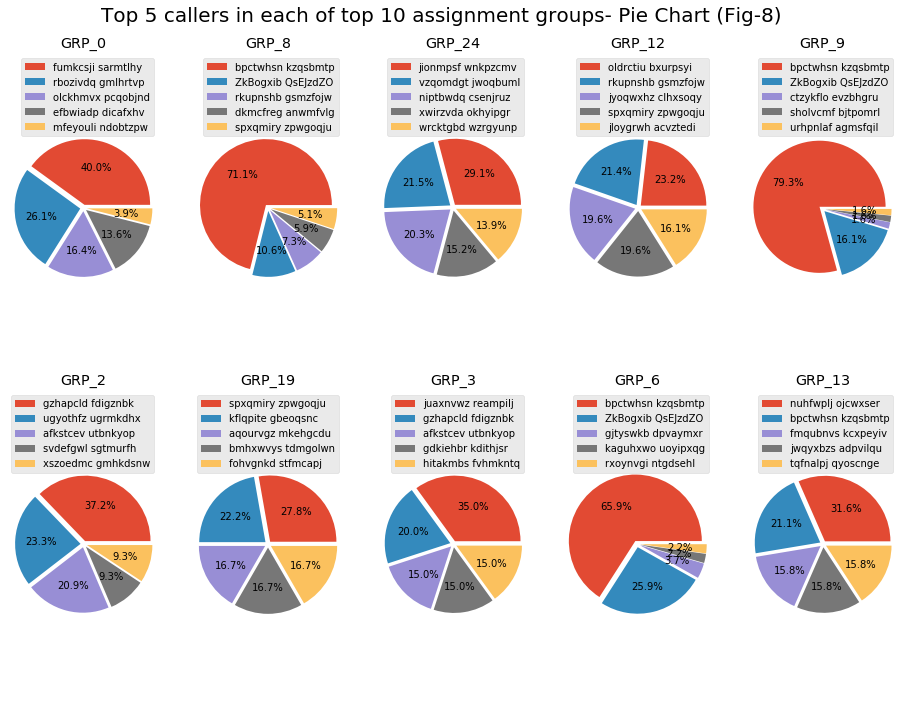

In [12]:
# Visualize Top 5 callers in each of top 10 assignment groups
top_n = 10
top_grps = assgn_grp.nlargest(top_n, 'Count')['Assignment group'].tolist()

fig_cols = 5
fig_rows = int(np.ceil(top_n/fig_cols))
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(13,9.5))
fig.suptitle('Top 5 callers in each of top 10 assignment groups- Pie Chart (Fig-8)', y=1, va= 'bottom', size='20')
for row in range(fig_rows):
    for col in range(fig_cols):
        grp_n = fig_cols * row + col
        if grp_n < top_n:
            xs = caller_grp.xs(top_grps[grp_n])
            _ = axes[row,col].pie(xs, autopct='%1.1f%%', explode=[0.05]*5)
            axes[row,col].legend(labels=xs.index,loc="best")
            axes[row,col].axis('equal')
            axes[row,col].set_title(top_grps[grp_n])

plt.tight_layout()

In [13]:
# Check if any caller appears to raise ticket for multiple groups
mul_caller = caller_grp[caller_grp.Caller.duplicated()]
uni_mul_caller = [idx[1] for idx in mul_caller.index[mul_caller.Caller.unique()]]
print(f'\033[1mFollowing {len(uni_mul_caller)} callers happen to raise tickets for multiple groups:\033[0m\n')
print(uni_mul_caller)

mul_caller

Following 15 callers happen to raise tickets for multiple groups:

['hlrmufzx qcdzierm', 'fbgetczn jlsvxura', 'gnasmtvx cwxtsvkm', 'ihfkwzjd erbxoyqk', 'tqfnalpj qyoscnge', 'fmqubnvs kcxpeyiv', 'tghrloks jbgcvlmf', 'jwqyxbzs adpvilqu', 'nuhfwplj ojcwxser', 'oldrctiu bxurpsyi', 'vlymsnej whlqxcst', 'dkmcfreg anwmfvlg', 'bpctwhsn kzqsbmtp', 'spxqmiry zpwgoqju', 'obanjrhg rnafleys']


Caller
Assignment group Caller                   
GRP_1            spxqmiry zpwgoqju       3
GRP_10           ihfkwzjd erbxoyqk       6
                 gnasmtvx cwxtsvkm       3
                 hlrmufzx qcdzierm       3
GRP_11           tghrloks jbgcvlmf       2
...                                    ...
GRP_73           kcnosyae zlpmfxgs       1
GRP_8            ZkBogxib QsEJzdZO      54
GRP_9            ctzykflo evzbhgru       3
                 sholvcmf bjtpomrl       3
                 urhpnlaf agmsfqil       3

[281 rows x 1 columns]

**Comments:**
- There are 2950 callers have been captured in the entire dataset.
- 15 callers are identified to be involved in raising tickets for multiple assignment groups, there by contributing total 281 tickets in the dataset.
- The analysis of top 5 callers volume in each of the top 10 assignment groups shows a wide veriety of distributions in each pie chart. This is an indicative of the fact that each assignment group deals with issues impacting the business in NOT biased propertions.

#### The distribution of Short description lengths
Plots the variation of length and word count of Short description attribute

In [14]:
# Short Desc text length
ticket['sd_len'].iplot(
    kind='scatter',
    xTitle='text length',
    yTitle='count',
    title='Short Desc. Text Length Distribution (Fig-9)')

# Short desc word count
ticket['sd_word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    colorscale='pastel1',
    title='Short desc. Word Count Distribution (Fig-10)')

In [15]:
# Description text length
ticket['desc_len'].iplot(
    kind='bar',
    xTitle='text length',
    yTitle='count',
    colorscale='-ylgn',
    title='Description Text Length Distribution (Fig-11)')

# Description word count
ticket['desc_word_count'].iplot(
    kind='bar',
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    colorscale='-bupu',
    title='Description Word Count Distribution (Fig-12)')

**Comments:**
- It is observed that there were quite number of people like to leave long descriptions.

### N-Grams
N-gram is a contiguous sequence of N items from a given sample of text or speech, in the fields of computational linguistics and probability. The items can be phonemes, syllables, letters, words or base pairs according to the application. N-grams are used to describe the number of words used as observation points, e.g., unigram means singly-worded, bigram means 2-worded phrase, and trigram means 3-worded phrase. 

We'll be using scikit-learn’s CountVectorizer function to derive n-grams and compare them before and after removing stop words. Stop words are a set of commonly used words in any language.

But before that let's merge the Short descrition and Description column texts and write a generic method to derive the n-grams.

In [16]:
# Merge the Short descrition and Description column texts
ticket['Summary'] = ticket['Short description'].str.strip() + ' ' + ticket['Description'].str.strip()

# Generic function to derive top N n-grams from the corpus
def get_top_n_ngrams(corpus, top_n=None, ngram_range=(1,1), stopwords=None):
    vec = CountVectorizer(ngram_range=ngram_range, 
                          stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_n]

### Top Unigrams

In [17]:
# Top 50 Unigrams before removing stop words
top_n = 50
ngram_range = (1,1)
uni_grams = get_top_n_ngrams(ticket.Summary, top_n, ngram_range)

df = pd.DataFrame(uni_grams, columns = ['Summary' , 'count'])
df.groupby('Summary').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    colorscale='piyg',
    title=f'Top {top_n} Unigrams in Summary')

# Top 50 Unigrams after removing stop words
uni_grams_sw = get_top_n_ngrams(ticket.Summary, top_n, ngram_range, stopwords='english')

df = pd.DataFrame(uni_grams_sw, columns = ['Summary' , 'count'])
df.groupby('Summary').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black',
    colorscale='-piyg',
    title=f'Top {top_n} Unigrams in Summary without stop words')

### Top Bigrams

In [18]:
# Top 50 Bigrams before removing stop words
top_n = 50
ngram_range = (2,2)
bi_grams = get_top_n_ngrams(ticket.Summary, top_n, ngram_range)

df = pd.DataFrame(bi_grams, columns = ['Summary' , 'count'])
df.groupby('Summary').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    colorscale='piyg',
    title=f'Top {top_n} Bigrams in Summary')

# Top 50 Bigrams after removing stop words
bi_grams_sw = get_top_n_ngrams(ticket.Summary, top_n, ngram_range, stopwords='english')

df = pd.DataFrame(bi_grams_sw, columns = ['Summary' , 'count'])
df.groupby('Summary').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black',
    colorscale='-piyg',
    title=f'Top {top_n} Bigrams in Summary without stop words')

### Top Trigrams

In [19]:
# Top 50 Trigrams before removing stop words
top_n = 50
ngram_range = (3,3)
tri_grams = get_top_n_ngrams(ticket.Summary, top_n, ngram_range)

df = pd.DataFrame(tri_grams, columns = ['Summary' , 'count'])
df.groupby('Summary').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    colorscale='piyg',
    title=f'Top {top_n} Trigrams in Summary')

# Top 50 Trigrams after removing stop words
tri_grams_sw = get_top_n_ngrams(ticket.Summary, top_n, ngram_range, stopwords='english')

df = pd.DataFrame(tri_grams_sw, columns = ['Summary' , 'count'])
df.groupby('Summary').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black',
    colorscale='-piyg',
    title=f'Top {top_n} Trigrams in Summary without stop words')

### Word Cloud
A word cloud is a collection, or cluster, of words depicted in different sizes. The bigger and bolder the word appears, the more often it’s mentioned within a given text and the more important it is.

Also known as tag clouds or text clouds, these are ideal ways to pull out the most pertinent parts of textual data, often also help business users compare and contrast two different pieces of text to find the wording similarities between the two.

Let's write a generic method to generate Word Clouds for both Short and Long Description columns

In [20]:
def generate_word_clod(corpus):
    # Instantiate the wordcloud object
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords=STOPWORDS,
                    min_font_size = 10).generate(corpus)

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

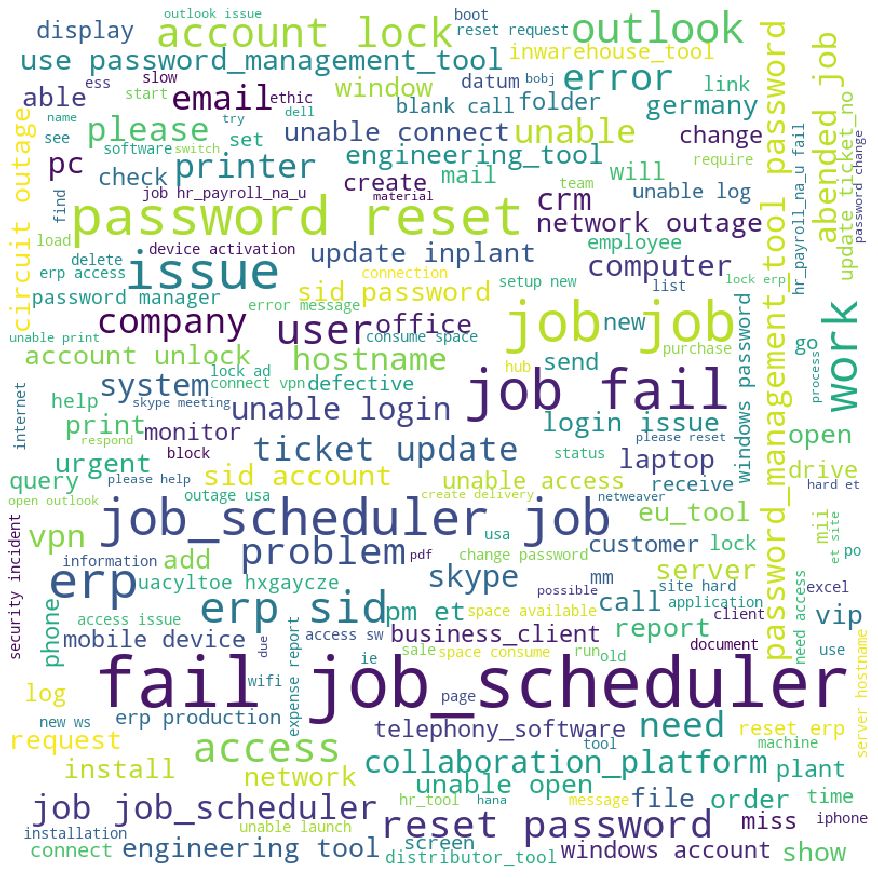

In [21]:
# Generate wordcloud for ticket Short description
generate_word_clod(' '.join(ticket['Short description'].str.strip()))

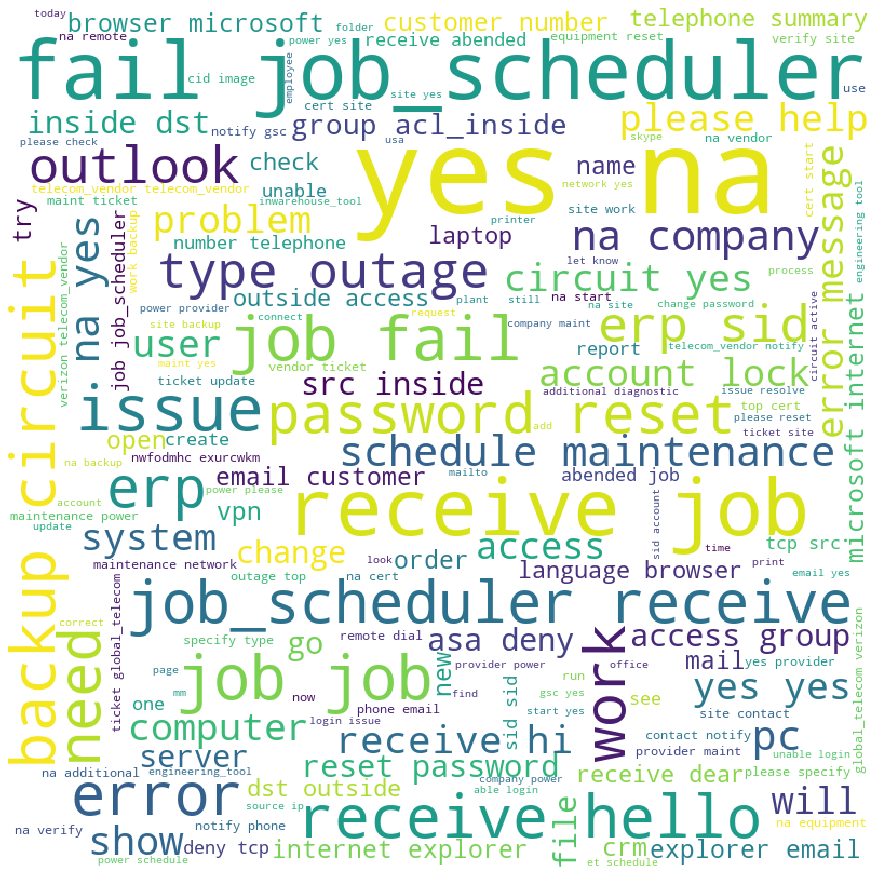

In [22]:
# Generate wordcloud for ticket Description
generate_word_clod(' '.join(ticket.Description.str.strip()))